# Simulation Library Demo

In [51]:
from class_multisimulation import MultiSimulation
from class_simulationhelper import SimulationHelpers
from class_basesimulation import BaseSimulation
import matplotlib.pyplot as plt

bs = BaseSimulation()
ms = MultiSimulation()
helper = SimulationHelpers()


outlier added at indices 89, 44, 36, 30, 48, 68, 98, 29, 52, 63


Text(0.5, 0, 'Added Outliers')

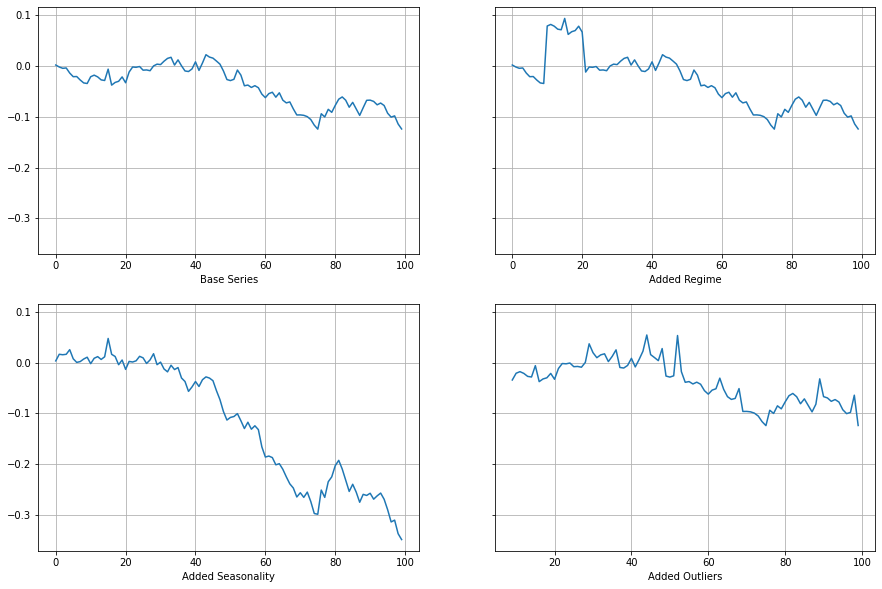

In [64]:
s0 = bs.brownian_process(100, mu = 0, S0 = 1, sigma = 0.1)
s1 = bs.add_regime_change(s0, event_index = 10, shift = 0.1, regime_limit = 10)
s2 = bs.add_seasonality(s0, start_idx = 10, how_diffusion="sqrt", amp = 3, contamination=0.1, freq = 100)
s3 = bs.add_outlier(s0, thresh=3, how = "full_random", count = 10)
ax = helper.plot(s0, s1, s2, s3, figsize=(15, 10), row_lim = 2)
ax[0,0].set_xlabel("Base Series")
ax[0,1].set_xlabel("Added Regime")
ax[1,0].set_xlabel("Added Seasonality")
ax[1,1].set_xlabel("Added Outliers")

outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 20, 35
outlier added at indices 80
outlier added at indices 30


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[66 10 64 45 70 22 89 55 90 45]. Argument 'count' overridden.
  warnings.warn(
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[20, 35]. Argument 'count' overridden.
  warnings.warn(
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[80]. Argument 'count' overridden.
  warnings.warn(
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[30]. Argument 'count' overridden.
  warnings.warn(


Text(0.5, 0.98, 'Systematic Outliers in Rainbow; Idiosyncratic Outliers in Black')

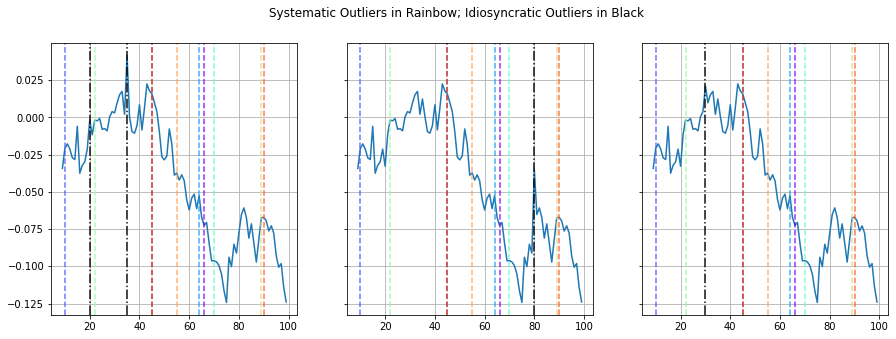

In [75]:
t0 = ms.correlated_brownian_processes_with_CO(100, how = "full_random", count = 10, mu = 0, cov_mat = helper.gen_rand_cov_mat(3, random_seed=12), random_seed=12)
io0 = [20, 35]
io1 = [80]
io2 = [30]
t0[0] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io0)
t0[1] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io1)
t0[2] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io2)
ax = helper.plot(*t0, figsize = (15, 5), outliers = [[66, 10, 64, 45, 70, 22, 89, 55, 90, 45] for _ in range(3)])
for idio in io0:
    ax[0].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
for idio in io1:
    ax[1].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
for idio in io2:
    ax[2].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
plt.suptitle("Systematic Outliers in Rainbow; Idiosyncratic Outliers in Black")

In [76]:
# Graph different architecture loss descents
# All copied from new_fit.ipynb
import tensorflow as tf
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_generation import gen_data
# from pyod.utils import pairwise_distances_no_broadcast
# from dense_autoencoder import DENSE_Model
from lstm_autoencoder import LSTM_Model_Base
from class_simulationhelper import SimulationHelpers
from lstm_autoencoder import DataGeneration
from lstm_autoencoder import reconstruction
from model_exec import lstm_run, temporalize, reconstruction, get_outliers

featured_credit = pd.read_csv(r'data\featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
# n_companies = 6
np.random.seed(25)

n_companies = 8
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)

def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features.shape


(2503, 24)

In [77]:
seq_size = 5
n_feature = features.shape[1]

data = features.values
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)


In [80]:
architectures = [
    [128, 64, 64, 128],
    [128, 64, 32, 32, 64, 128],
    [128, 32, 32, 128],
    [64, 32, 32, 64],
    [32, 16, 16, 32],
    [128, 16, 16, 128]
]

histories = {"-".join([str(i) for i in arch]):[] for arch in architectures}

for arch in architectures:
    lstm_pred, lstm_outliers, history = lstm_run(
        LSTM_Model_Base(
            seq_size, 
            n_feature, 
            arch, 
            mid_activation=tf.nn.tanh
        ),
        data_train_seq,
        data_test_seq,
        batch_size=512,
        epoch=100,
        metric="bb",
        early_stopping=False,
        cross_feature_check=True
    )

    histories["-".join([str(i) for i in arch])] = history


Epoch 1/100
3/3 [==============================] - 6s 64ms/step - loss: 1.0156
Epoch 2/100
3/3 [==============================] - 0s 66ms/step - loss: 1.0145
Epoch 3/100
3/3 [==============================] - 0s 67ms/step - loss: 1.0131
Epoch 4/100
3/3 [==============================] - 0s 74ms/step - loss: 1.0108
Epoch 5/100
3/3 [==============================] - 0s 63ms/step - loss: 1.0072
Epoch 6/100
3/3 [==============================] - 0s 72ms/step - loss: 1.0017
Epoch 7/100
3/3 [==============================] - 0s 69ms/step - loss: 0.9961
Epoch 8/100
3/3 [==============================] - 0s 66ms/step - loss: 0.9923
Epoch 9/100
3/3 [==============================] - 0s 70ms/step - loss: 0.9866
Epoch 10/100
3/3 [==============================] - 0s 64ms/step - loss: 0.9810
Epoch 11/100
3/3 [==============================] - 0s 77ms/step - loss: 0.9757
Epoch 12/100
3/3 [==============================] - 0s 75ms/step - loss: 0.9705
Epoch 13/100
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 5ms/step


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


TypeError: unhashable type: 'list'